In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [116]:
rankings = pd.read_csv('fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted']\
                             + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup = pd.read_csv('World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

In [118]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [119]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

# I tried earlier rest days but it did not turn to be useful
max_rest = 30
matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))

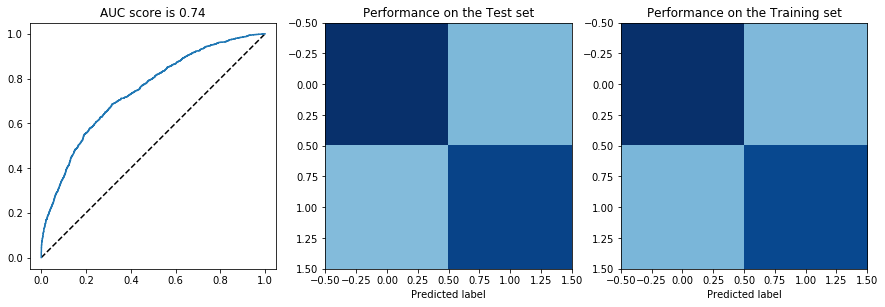

In [124]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['rank_home', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

Stakes distribution in the wrong predictions
True     0.579574
False    0.420426
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.615618
False    0.384382
Name: is_stake, dtype: float64


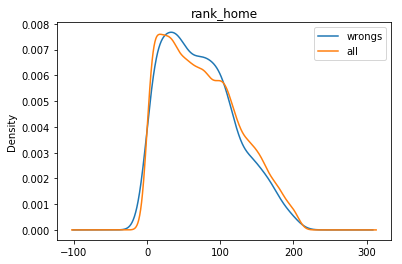

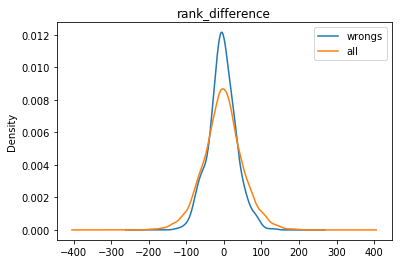

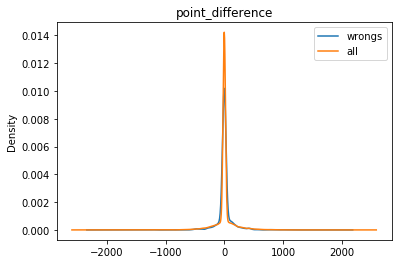

In [125]:
features = ['rank_home', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

In [126]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [127]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        row['rank_home'] = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['rank_difference'] = row['rank_home'] - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group C:___
France vs. Australia: France wins with 0.65
France vs. Peru: Draw
France vs. Denmark: Draw
Australia vs. Peru: Peru wins with 0.67
Australia vs. Denmark: Denmark wins with 0.70
Peru vs. Denmark: Draw
___Starting group D:___
Argentina vs. Iceland: Argentina wins with 0.60
Argentina vs. Croatia: Argentina wins with 0.59
Argentina vs. Nigeria: Argentina wins with 0.70
Iceland vs. Croatia: Draw
Iceland vs. Nigeria: Iceland wins with 0.62
Croatia vs. Nigeria: Croatia wins with 0.63
___Starting group B:___
Portugal vs. Spain: Draw
Portugal vs. Morocco: Portugal wins with 0.68
Portugal vs. Iran: Portugal wins with 0.67
Spain vs. Morocco: Spain wins with 0.65
Spain vs. Iran: Spain wins with 0.64
Morocco vs. Iran: Draw
___Starting group G:___
Belgium vs. Panama: Belgium wins with 0.73
Belgium vs. Tunisia: Belgium wins with 0.61
Belgium vs. England: Belgium wins with 0.57
Panama vs. Tunisia: Tunisia wins with 0.73
Panama vs. England: England wins with 0.77
Tunisia vs. Eng

In [128]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        row['rank_home'] = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['rank_difference'] = row['rank_home'] - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.54
Denmark vs. Croatia: Denmark wins with probability 0.55
Brazil vs. Mexico: Brazil wins with probability 0.58
Belgium vs. Colombia: Belgium wins with probability 0.59
Egypt vs. Portugal: Portugal wins with probability 0.81
France vs. Argentina: Argentina wins with probability 0.53
Switzerland vs. Germany: Germany wins with probability 0.60
England vs. Poland: Poland wins with probability 0.53


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.51
Brazil vs. Belgium: Belgium wins with probability 0.51
Portugal vs. Argentina: Portugal wins with probability 0.51
Germany vs. Poland: Germany wins with probability 0.57


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.57
Portugal vs. Germany: Germany wins with probability 0.56


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.54




In [132]:
import networkx as nx
import pydot 
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi', args='')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()

ModuleNotFoundError: No module named 'pydot'

In [15]:
goals_scored_home = df.groupby('home_team')['home_score'].agg(['mean', 'sum'])

In [16]:
goals_scored_away = df.groupby('away_team')['away_score'].agg(['mean', 'sum'])

In [17]:
total_goals_scored = goals_scored_home + goals_scored_away

In [20]:
total_goals_scored.sort_values('sum', ascending=False)

,mean,sum
England,4.375863,2136.0
Germany,4.455870,2085.0
Brazil,4.274995,2084.0
Sweden,4.009880,1976.0
Hungary,4.106662,1866.0
Argentina,3.640579,1779.0
Netherlands,4.073867,1580.0
Korea Republic,3.494073,1471.0
Mexico,3.341331,1445.0
France,3.464136,1438.0


In [21]:
total_goals_scored.sort_values('mean', ascending=False)

,mean,sum
North Vietnam,5.231579,49.0
Tahiti,5.135721,488.0
New Caledonia,5.056022,543.0
Papua New Guinea,4.936335,256.0
Germany,4.455870,2085.0
Solomon Islands,4.412500,325.0
England,4.375863,2136.0
Brazil,4.274995,2084.0
Fiji,4.155012,449.0
Hungary,4.106662,1866.0


In [33]:
conditions  = [ df['home_score'] > df['away_score'], df['home_score'] < df['away_score'] ]
choices     = [df['home_team'], df['away_team'] ]

df['Winner'] = np.select(conditions, choices, default='Draw')
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Winner
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,Draw
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,England
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,Draw
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,Scotland
5,1876-03-25,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,False,Scotland
6,1877-03-03,England,Scotland,1,3,Friendly,London,England,False,Scotland
7,1877-03-05,Wales,Scotland,0,2,Friendly,Wrexham,Wales,False,Scotland
8,1878-03-02,Scotland,England,7,2,Friendly,Glasgow,Scotland,False,Scotland
9,1878-03-23,Scotland,Wales,9,0,Friendly,Glasgow,Scotland,False,Scotland


In [38]:
df.groupby('Winner').count().sort_values('date', ascending=False).iloc[:,1]

Winner
Draw                         9057
Brazil                        606
England                       554
Germany                       545
Argentina                     512
Sweden                        487
Korea Republic                438
Hungary                       427
Mexico                        420
Italy                         412
France                        398
Spain                         389
Netherlands                   388
Uruguay                       372
Scotland                      361
Denmark                       347
Russia                        343
Poland                        339
Zambia                        317
Austria                       314
Belgium                       312
Romania                       299
Egypt                         299
Trinidad and Tobago           286
Portugal                      285
Norway                        284
Chile                         284
Japan                         284
Saudi Arabia                  283
USA    

In [ ]:
#wins, losses, draws



In [52]:


df = pd.read_csv('results.csv')

In [79]:
#use past match scores (in friendlies) to predict world cup results (based on linear reg?)

#select 2010-2014 friendlies to predict 2014 world cup winner
df1 = df[(df['date'] >= '2010-07-12') & (df['date'] <= '2014-07-13')] 
df1


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Winner
31741,2010-08-04,Botswana,Zimbabwe,2,0,Friendly,Selebi-Phikwe,Botswana,False,Botswana
31742,2010-08-08,Anguilla,St. Martin,1,3,Friendly,The Valley,Anguilla,False,St. Martin
31743,2010-08-10,Bosnia-Herzegovina,Qatar,1,1,Friendly,Sarajevo,Bosnia-Herzegovina,False,Draw
31744,2010-08-10,Italy,Ivory Coast,0,1,Friendly,London,England,True,Ivory Coast
31745,2010-08-10,USA,Brazil,0,2,Friendly,East Rutherford,USA,False,Brazil
31746,2010-08-11,Albania,Uzbekistan,1,0,Friendly,Durrës,Albania,False,Albania
31747,2010-08-11,Algeria,Gabon,1,2,Friendly,Algiers,Algeria,False,Gabon
31748,2010-08-11,Angola,Uruguay,0,2,Friendly,Lisbon,Portugal,True,Uruguay
31749,2010-08-11,Armenia,Iran,1,3,Friendly,Yerevan,Armenia,False,Iran
31750,2010-08-11,Austria,Switzerland,0,1,Friendly,Klagenfurt,Austria,False,Switzerland


In [108]:
df1_fri = df1[df1['tournament']!='FIFA World Cup']
df1_wc = df1[df1['tournament']=='FIFA World Cup']

In [109]:
df1_fri

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Winner
31741,2010-08-04,Botswana,Zimbabwe,2,0,Friendly,Selebi-Phikwe,Botswana,False,Botswana
31742,2010-08-08,Anguilla,St. Martin,1,3,Friendly,The Valley,Anguilla,False,St. Martin
31743,2010-08-10,Bosnia-Herzegovina,Qatar,1,1,Friendly,Sarajevo,Bosnia-Herzegovina,False,Draw
31744,2010-08-10,Italy,Ivory Coast,0,1,Friendly,London,England,True,Ivory Coast
31745,2010-08-10,USA,Brazil,0,2,Friendly,East Rutherford,USA,False,Brazil
31746,2010-08-11,Albania,Uzbekistan,1,0,Friendly,Durrës,Albania,False,Albania
31747,2010-08-11,Algeria,Gabon,1,2,Friendly,Algiers,Algeria,False,Gabon
31748,2010-08-11,Angola,Uruguay,0,2,Friendly,Lisbon,Portugal,True,Uruguay
31749,2010-08-11,Armenia,Iran,1,3,Friendly,Yerevan,Armenia,False,Iran
31750,2010-08-11,Austria,Switzerland,0,1,Friendly,Klagenfurt,Austria,False,Switzerland


In [111]:
df1_fri.groupby('Winner').count().sort_values('date', ascending=False)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
Winner,,,,,,,,,
Draw,929,929,929,929,929,929,929,929,929
Spain,40,40,40,40,40,40,40,40,40
Brazil,37,37,37,37,37,37,37,37,37
Kuwait,35,35,35,35,35,35,35,35,35
USA,34,34,34,34,34,34,34,34,34
Mexico,34,34,34,34,34,34,34,34,34
Panama,33,33,33,33,33,33,33,33,33
Iraq,33,33,33,33,33,33,33,33,33
Iran,32,32,32,32,32,32,32,32,32


In [112]:
df1_wc

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Winner
35524,2014-06-12,Brazil,Croatia,3,1,FIFA World Cup,São Paulo,Brazil,False,Brazil
35525,2014-06-13,Chile,Australia,3,1,FIFA World Cup,Cuiabá,Brazil,True,Chile
35526,2014-06-13,Mexico,Cameroon,1,0,FIFA World Cup,Natal,Brazil,True,Mexico
35527,2014-06-13,Spain,Netherlands,1,5,FIFA World Cup,Salvador,Brazil,True,Netherlands
35528,2014-06-14,Colombia,Greece,3,0,FIFA World Cup,Belo Horizonte,Brazil,True,Colombia
35529,2014-06-14,England,Italy,1,2,FIFA World Cup,Manaus,Brazil,True,Italy
35530,2014-06-14,Ivory Coast,Japan,2,1,FIFA World Cup,Recife,Brazil,True,Ivory Coast
35531,2014-06-14,Uruguay,Costa Rica,1,3,FIFA World Cup,Fortaleza,Brazil,True,Costa Rica
35532,2014-06-15,Argentina,Bosnia-Herzegovina,2,1,FIFA World Cup,Rio de Janeiro,Brazil,True,Argentina
35533,2014-06-15,France,Honduras,3,0,FIFA World Cup,Porto Alegre,Brazil,True,France


In [22]:
#list of countries qualified
qualified_countries = ['Russia','Brazil','Iran','Japan','Mexico','Belgium','South Korea','Saudi Arabia','Germany','England',
                       'Spain','Nigeria','Costa Rica','Poland','Egypt','Iceland','Serbia','Portugal','France','Uruguay',
                       'Argentina','Colombia','Panama','Senegal','Morocco','Tunisia','Switzerland','Croatia','Sweden','Denmark',
                       'Australia','Peru']

In [ ]:
#predict each match outcome



In [ ]:
#use odds from betting sites



In [ ]:
#impact of home-ground advantage

